# Introduction
---

This project aims to classify Face Skin Diseases by using the power of deep learning concepts.

</br>

Firstly, custom **CNN Models** were used and then pretrained **MobileNet V2** was used with **Transfer Learning.** At the end, **Fine tuning** was done to increase the model performance. You can see how the accuracy on unused test images increases in each step.

I created this Jupyter Notebook largely by using these 2 TensorFlow Tutorials ; [Image classification](https://www.tensorflow.org/tutorials/images/classification) and [Transfer Learning.](https://www.tensorflow.org/tutorials/images/transfer_learning)


</br>

This notebook can be taken as pipeline and used in different platforms. But it was designed to train the models with [*Intel Extension for TensorFlow*](https://intel.github.io/intel-extension-for-tensorflow/latest/get_started.html) on **Intel Developer Cloud** to accelerate training.

Later, the trained TensorFlow models are converted into **ONNX** and **TensorRT** formats and used in NVIDIA Jetson Nano to inference.

</br>

The dataset is based on [Dermnet dataset](https://www.kaggle.com/code/gauravduttakiit/class-dataset-face-skin-diseases/input) which has different types of skin diseases.

But, in this project I used the smaller dataset which focus only [Face Skin Diseases.](https://www.kaggle.com/datasets/shubhamgoel27/dermnet)

# Installation
---

The project has 2 main part :  
- Intel Developer Cloud
- NVIDIA Jetson Nano

This notebook is about **Model Training on Intel Developer Cloud.** The necassary installation steps and creating a suitable Kernel to be able to use ***Intel Optimized TensorFlow***, can be found in this [Github section.]()

</br>

The information about **Jetson Nano**, its setup and **Docker Image** which contains necassary packages can be found in this [Github section.]()

# Import Libraries

In [27]:
import os
import PIL
import cv2
import time
import json
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D


# Set Global Variables

In [2]:
num_classes = 5
batch_size = 32
img_height = 160 # MobileNet accepts this size as input
img_width = 160 # Thus, it is adjusted like this for the custom model as well.

# Define callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.05, patience=3)

train_dir = pathlib.Path("/home/u198181/0image_classification/DATA/train/")
test_dir = pathlib.Path("/home/u198181/0image_classification/DATA/testing/")

model1_save_path = "/home/u198181/0image_classification/tf_model1"
model2_save_path = "/home/u198181/0image_classification/tf_model2"
mobilenet_save_path = "/home/u198181/0image_classification/tf_mobilenet"
mobilenet_fine_save_path = "/home/u198181/0image_classification/tf_mobilenet_fine"


# Helper Functions

They are used to show some information about the model performance and training proces.

In [3]:
# Plot adjusted metrics and their changes during training.
def plot_metrics(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('Accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('Loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

In [4]:
%%capture
# After the training, calculates model performance on unused Test images
def calculate_values_on_test_images(model):

  (eval_loss, eval_accuracy) = model.evaluate(test_dataset, batch_size=batch_size,verbose=1)
  """
  print("----------------------------------")
  print("Accuracy on Test Images : " ,eval_accuracy )
  print("Loss on Test Images : " ,eval_loss )
  print("----------------------------------")
  """
  return eval_loss, eval_accuracy



In [5]:
def show_values(eval_loss, eval_accuracy):
    print("----------------------------------")
    print("Accuracy on Test Images : " ,eval_accuracy )
    print("Loss on Test Images : " ,eval_loss )
    print("----------------------------------")

In [6]:
%%capture
# Show the predictions on some test images
def make_predictions(model):
    # Retrieve a batch of images from the test set
    image_batch, label_batch = test_dataset.as_numpy_iterator().next()

    my_label = np.empty(32, dtype=int)

    for i in range (batch_size):
        img = image_batch[i]
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        my_label[i] = int(np.argmax(score))

    return my_label,label_batch,image_batch



In [7]:
def show_predictions(my_label,label_batch,image_batch):
    print('Predicted Labels:\n', my_label)
    print('Labels:\n', label_batch)

    plt.figure(figsize=(10, 10))
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(image_batch[i].astype("uint8"))
      plt.title(class_names[my_label[i]])
      plt.axis("off")
    plt.show()


    # Calculate the confusion matrix
    cm = confusion_matrix(my_label, label_batch)

    # Plot the confusion matrix using Seaborn
    sns.heatmap(cm, annot=True, cmap='Blues')



In [8]:
# This single functions, run the all model evaluation methods.

def model_evaluation(model, history):

  eval_loss, eval_accuracy=calculate_values_on_test_images(model)
  my_label,label_batch,image_batch=make_predictions(model)

  plot_metrics(history)
  show_values(eval_loss, eval_accuracy)
  show_predictions(my_label,label_batch,image_batch)

In [33]:
# To run the model on test folder and make the predictions
def model_inference_on_test_images(folder_path, loaded_model,label):
    img_height, img_width = (160,160)
    class_labels = []


    # Get a list of all files in the folder
    file_list = os.listdir(folder_path)

    # Loop through each file in the list
    for i, file_name in enumerate(file_list):
        if file_name.endswith(".jpg"):
            # Construct the full path of the image
            image_path = os.path.join(folder_path, file_name)

            # Read the image using OpenCV
            #image = cv2.imread(image_path)

            img = tf.keras.utils.load_img(
                image_path, target_size=(img_height, img_width)
            )

            img_array = tf.keras.utils.img_to_array(img)

            img_array = np.array([img_array]) # Convert single image to a batch.


            predictions = loaded_model.predict(img_array)
            score = tf.nn.softmax(predictions[0])

            class_labels.append(int(np.argmax(score)))
    #print(class_labels)


    count = 0
    for correct_result in class_labels:
        if correct_result == label:
            count = count +1
    #print(count)

    return class_labels, count

# Prepare Dataset

This part shows, creating the Dataset from very beginning to the final result with all necessary operations.

## Read Path and Show Data

In [10]:
image_count_train = len(list(train_dir.glob('*/*.jpg')))
print("Number of Train Images : ",image_count_train)
image_count_test = len(list(test_dir.glob('*/*.jpg')))
print("Number of Test Images  : ",image_count_test)

Number of Train Images :  440
Number of Test Images  :  183


## Split Data into Train, Validation and Test





When I searced creating dataset, I saw that generally there are 2 methods :

</br>

* [According to the documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) _"tf.keras.preprocessing.image.ImageDataGenerator_ is deprecated.

</br>

* Therefore for dataset the following method [_"image_dataset_from_directory"_](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) was used.


  This method, does not apply [Data Augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation), therefore augmentation part was added separetely.

  </br>

The details can be seen in the TensorFlow website by clicking the corresponding words above.

</br>




In [11]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  shuffle=True,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 440 files belonging to 5 classes.


In [12]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  shuffle=True,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 440 files belonging to 5 classes.
Using 88 files for validation.


In [13]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 185 files belonging to 5 classes.


In [14]:
class_names = train_dataset.class_names
print(class_names)

['Acne', 'Actinic Keratosis', 'Basal Cell Carcinoma', 'Eczemaa', 'Rosacea']


In the dataset, there are equal samples from each class. So we don't need to do anything extra.

total training image count = 440 

-------------------------------------
Class name =  Acne
count      =  88
proportion =  0.2
-------------------------------------
Class name =  Actinic Keratosis
count      =  88
proportion =  0.2
-------------------------------------
Class name =  Basal Cell Carcinoma
count      =  88
proportion =  0.2
-------------------------------------
Class name =  Eczemaa
count      =  88
proportion =  0.2
-------------------------------------
Class name =  Rosacea
count      =  88
proportion =  0.2
-------------------------------------


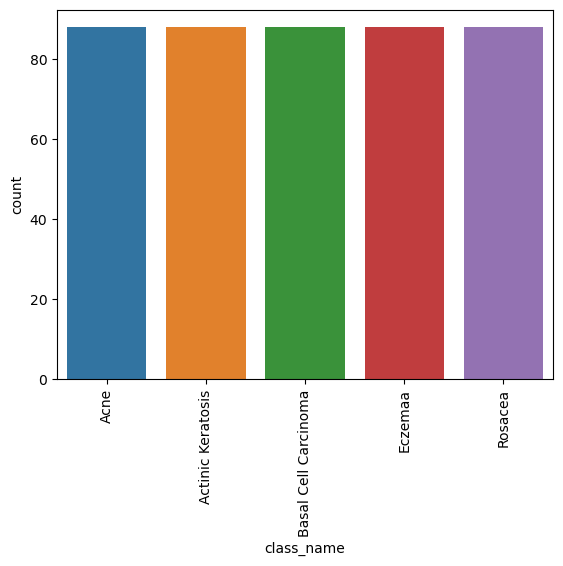

In [15]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []
for i in range(num_classes):
  count = len(list(train_dir.glob(class_names[i]+'/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(train_dir.glob(class_names[i]+'/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])

temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

Show some images and labels from the training set

2023-08-10 04:09:10.587536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


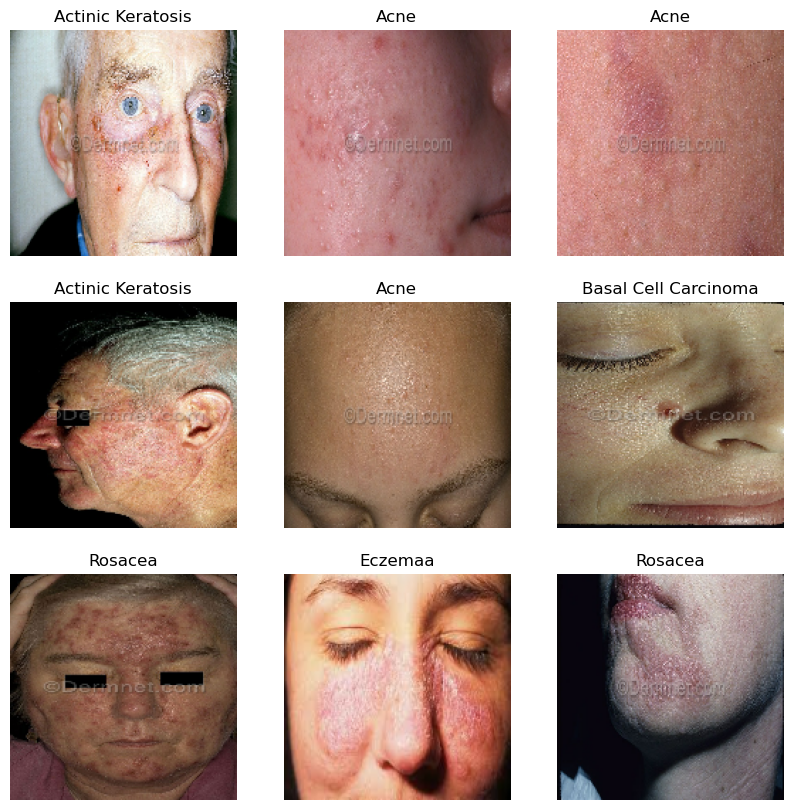

In [16]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


## Data Augmentation

There are 2 methods to apply data augmentation.

First the data augmentation should be defined as Keras layers. Then ;

- They can be applied to the dataset and later model training is started.

- Or, augmentation layers added, in the beginning of model structure.

</br>

I used the first method in this project, but the more details can be seen on [Data Augmentation Website](https://www.tensorflow.org/tutorials/images/data_augmentation) of TensorFlow.

</br>

Also, the all possible data augmentation options can also be found the relevant [Keras Website.](https://keras.io/guides/preprocessing_layers/)





In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.5, 0.2),
    layers.RandomContrast(0.3, seed=123),
    layers.RandomTranslation(0.2, 0.4),
    layers.RandomFlip(mode="horizontal_and_vertical", seed=412)
  ]
)

Show the effects of Data Augmentation options :

2023-08-10 04:09:20.759719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


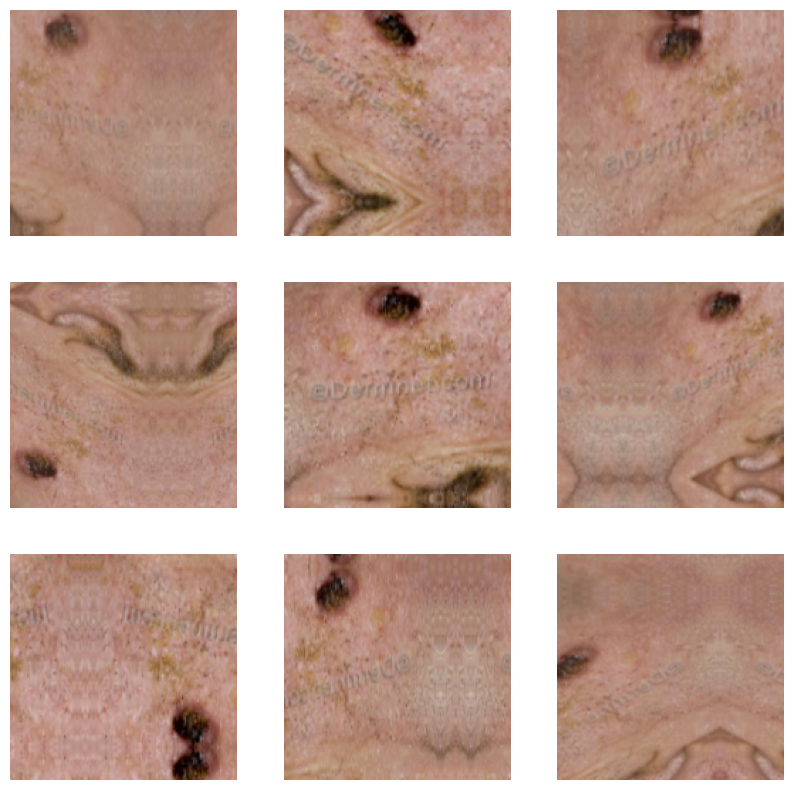

In [18]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Apply Augmentation Options to the train data :

In [19]:
aug_train_dataset = train_dataset.map(
  lambda x, y: (data_augmentation(x, training=True), y))

## Normalization

RGB channel values are in the [0, 255] range.

Since this is not ideal for a neural network ; we standardize values between [0, 1].

Similar to Data Augmentation, Rescaling can be used in 2 different ways :

- It can be applied to the training data

- Or it can be added to the beginning of model structure.

</br>

Again, I preferred to apply to the data directly

In [20]:
normalization_layer = layers.Rescaling(1./255)

In [21]:
normalized_train_dataset = aug_train_dataset.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train_dataset))
first_image = image_batch[0]

# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

2023-08-10 04:09:35.913801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 04:09:36.002519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 04:09:36.008225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


0.14457212 0.7546853


## Configure the dataset for performance
[According to the TensorFlow website](https://www.tensorflow.org/tutorials/images/classification#configure_the_dataset_for_performance), there are two important methods you should use when loading data :

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model.

- `Dataset.prefetch` overlaps data preprocessing and model execution while training.


In [22]:
AUTOTUNE = tf.data.AUTOTUNE

normalized_train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Now, everything is ready for Model Training.

</br>

The more details about the data which will be used in training :

- The `image_batch` is a tensor and consists of 32 images with shape 160x160x3 (the last dimension refers to color channels RGB).   

- The `label_batch``
 is a tensor of the shape (32,), these are corresponding labels to the 32 images.



In [23]:
for image_batch, labels_batch in train_dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 160, 160, 3)
(32,)


2023-08-10 04:09:43.621286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


# Train Custom CNN Model

Model1 and Model2 are relaed with this part.

# Model 1

I did not train Models for a certain number of epochs. Instead, Keras decide it when to stop if validation loss does not improve for certain epochs.(Early Stopping)

The more details about **Keras Callbacks** can be found in their [website.](https://keras.io/api/callbacks/early_stopping/)

In [38]:
num_classes = 5

model = Sequential([
  #data_augmentation, # Since these options applied to data in the previous step,
  #layers.Rescaling(1./255), # There is no need to implement them in model structure
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])



In [39]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [40]:
history = model.fit(normalized_train_dataset,
                    validation_data=validation_dataset,
                    epochs=100, verbose=1,
                    callbacks=[early_stopping, reduce_lr] )

Epoch 1/100


2023-08-10 06:10:57.612871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:10:58.005788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


14/14 [==============================] - 5s 104ms/step - loss: 218.6174 - accuracy: 0.2000 - val_loss: 3.2147 - val_accuracy: 0.3750 - lr: 0.0010


2023-08-10 06:11:01.046381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:11:01.092152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


Epoch 2/100
14/14 [==============================] - 1s 79ms/step - loss: 1.8917 - accuracy: 0.3409 - val_loss: 1.2778 - val_accuracy: 0.4318 - lr: 0.0010
Epoch 3/100
14/14 [==============================] - 1s 81ms/step - loss: 1.3035 - accuracy: 0.4318 - val_loss: 1.2023 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/100
14/14 [==============================] - 1s 83ms/step - loss: 1.1987 - accuracy: 0.5250 - val_loss: 1.0169 - val_accuracy: 0.6136 - lr: 0.0010
Epoch 5/100
14/14 [==============================] - 1s 81ms/step - loss: 1.0126 - accuracy: 0.5886 - val_loss: 0.8064 - val_accuracy: 0.6932 - lr: 0.0010
Epoch 6/100
14/14 [==============================] - 1s 79ms/step - loss: 0.8873 - accuracy: 0.6636 - val_loss: 0.7040 - val_accuracy: 0.7841 - lr: 0.0010
Epoch 7/100
14/14 [==============================] - 1s 83ms/step - loss: 0.7416 - accuracy: 0.7091 - val_loss: 0.5816 - val_accuracy: 0.8182 - lr: 0.0010
Epoch 8/100
14/14 [==============================] - 1s 81ms/step - lo

In [49]:
model.save(model1_save_path)

INFO:tensorflow:Assets written to: /home/u198181/0image_classification/tf_model1/assets


INFO:tensorflow:Assets written to: /home/u198181/0image_classification/tf_model1/assets


## Convert TensorFlow Model into ONNX Format

- The following command should be run in the Terminal at DevCloud. Do not forget to modify the necassary paths.

- After the `--saved-model`, you should type the location of **"saved_model.pb"**

- After the `--output`, you can write any directory you want. But at the end you should write the name of your converted model with _"onnx"_ extension. (*For example in my case, it is `my_onnx_model.onnx`*)

In [ ]:
#Do Not Try to run in the cell, It will give error. Run inside the terminal with suitable conda environment

"""
python -m tf2onnx.convert --saved-model /<directory where your save_model.pb is located>/
--opset 13
--output /<directory where you want to save>/my_onnx_model.onnx
"""

Check if onnx model converted succesfully :

In [ ]:
import onnx

onnx_path = "/home/u198181/0image_classification/onnx_model1.onnx"

def is_onnx_model_valid(path):
    model = onnx.load(path)
    try:
        onnx.checker.check_model(model)
    except onnx.checker.ValidationError:
        return False
    return True


print(is_onnx_model_valid(onnx_path))

### Inference ONNX Model and Make Prediction

In [ ]:
import onnxruntime

onnx_model_path = "/home/u198181/0image_classification/onnx_model1.onnx"

session = onnxruntime.InferenceSession(onnx_model_path, None)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name
print(input_name)
print(output_name)

In [ ]:
import cv2
import json
import numpy as np

img_path = "/home/u198181/0image_classification/DATA/testing/Acne/032839HB.jpg"
img = cv2.imread(img_path)
img.resize((1, img_height, img_width, 3))
data = img

data = json.dumps({'data': img.tolist()})
data = np.array(json.loads(data)['data']).astype('float32')

The output should give a number, which represents one of the class

In [ ]:
result = session.run([output_name], {input_name: data})
prediction=int(np.argmax(np.array(result).squeeze(), axis=0))
print(prediction)

## Model Evaluation

2023-08-10 06:12:43.686801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


6/6 [==============================] - 0s 22ms/step - loss: 2.9369 - accuracy: 0.5568


2023-08-10 06:12:44.121249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


1/1 [==============================] - 0s 32ms/step


2023-08-10 06:12:44.325547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:44.329171: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:44.334491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:44.365391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:44.433540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:44.438443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:44.446268: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 24ms/step


2023-08-10 06:12:44.544847: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:44.549185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:44.555944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:44.608371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:44.612738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:44.619639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


1/1 [==============================] - 0s 27ms/step


2023-08-10 06:12:44.940414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:44.944797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:44.951378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:45.004644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:45.009803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:45.018085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:45.059854: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 30ms/step


2023-08-10 06:12:45.175819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:45.181123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:45.189368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:45.226377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:45.231498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:45.240567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:45.278934: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 28ms/step


2023-08-10 06:12:45.404452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:45.409626: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:45.417749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:45.470203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:45.475285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:45.483874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:45.536217: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 21ms/step


2023-08-10 06:12:45.608465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:45.652591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:45.657394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:45.665520: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:45.701065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:45.705984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:45.713865: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 21ms/step


2023-08-10 06:12:45.813808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:45.821286: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:45.861087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:45.865981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:45.874086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:45.909736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:45.914438: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 28ms/step


2023-08-10 06:12:46.016700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:46.051408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:46.055907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:46.063106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:46.104630: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:46.109217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:46.116411: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 21ms/step


2023-08-10 06:12:46.258875: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:46.263687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:46.271136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:46.308412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:46.312896: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:46.320016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:12:46.365733: I tensorflow/core/grappler/optimizers/cust

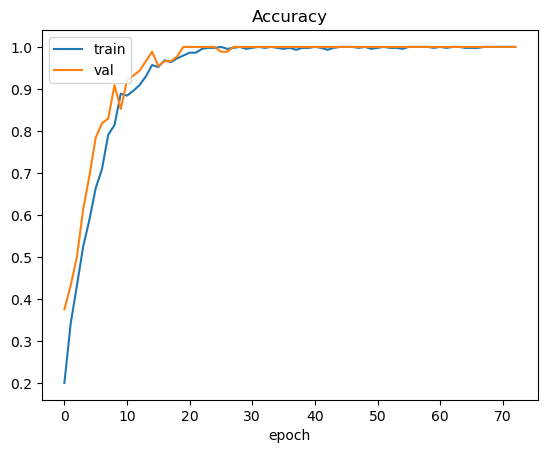

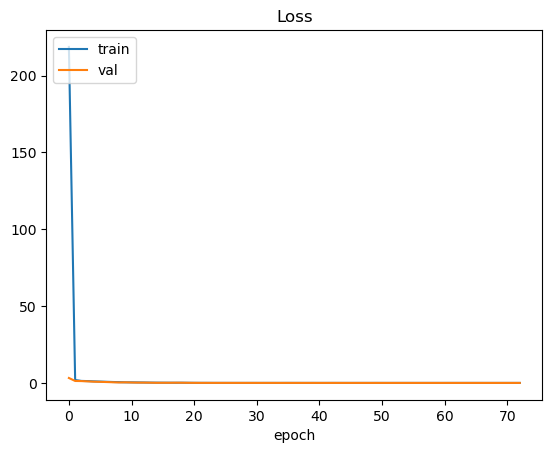

----------------------------------
Accuracy on Test Images :  0.5567567348480225
Loss on Test Images :  2.9369165897369385
----------------------------------
Predicted Labels:
 [0 4 4 4 3 3 4 3 4 0 4 1 0 0 2 1 3 0 2 4 0 3 2 2 0 1 3 2 2 4 4 1]
Labels:
 [3 4 1 3 3 3 1 0 0 0 4 2 0 0 1 1 4 0 1 1 0 3 3 0 0 1 4 2 2 4 4 2]


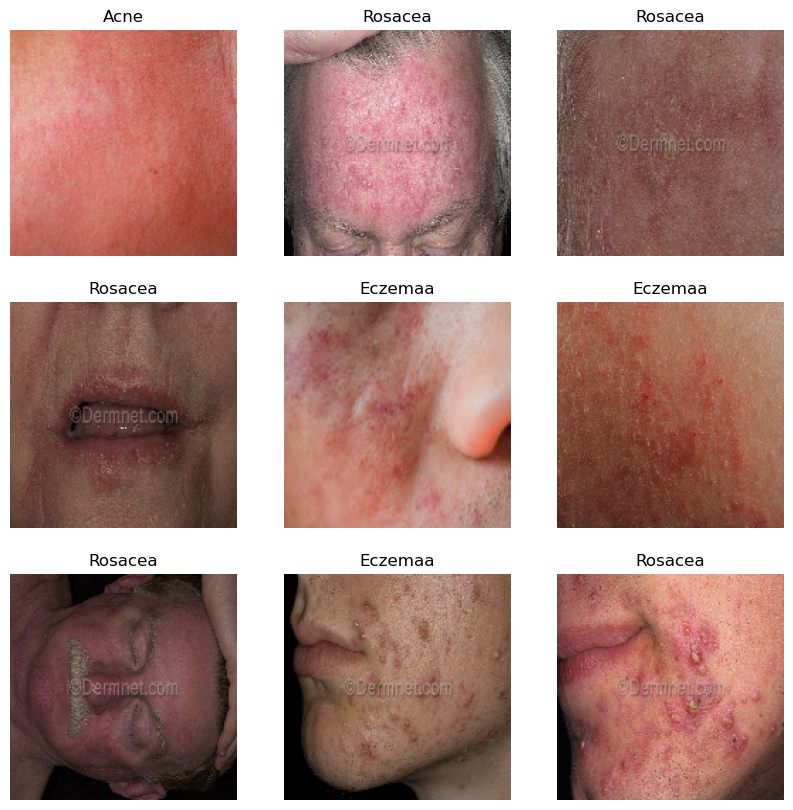

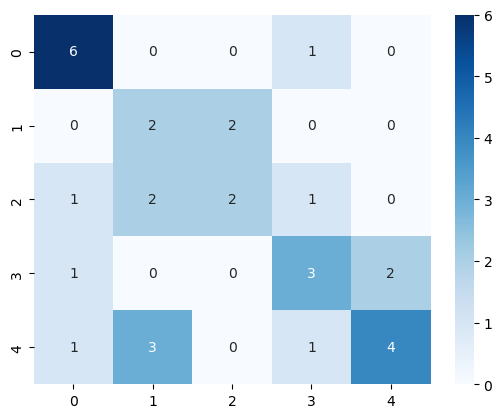

In [41]:
model_evaluation(model, history)

## Test Model On New Data

In [ ]:
# Test model on a single Image
test_image_path = "/home/u198181/0image_classification/DATA/testing/Eczemaa/eczem49.jpg"


img = tf.keras.utils.load_img(
    test_image_path, target_size=(img_height, img_width)
)

img_array = tf.keras.utils.img_to_array(img)

img_array = np.array([img_array]) # Convert single image to a batch.


predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 20ms/step
This image most likely belongs to Eczemaa with a 53.93 percent confidence.


2023-08-07 11:43:01.661306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:43:01.665277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:43:01.670841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


In [43]:
loaded_model = tf.keras.models.load_model(model1_save_path)

In [ ]:
test_images_folder0 = "/home/u198181/0image_classification/DATA/testing/Acne/"
test0_predicted_labels, correct0 = model_inference_on_test_images(test_images_folder0,loaded_model, label=0)

test_images_folder1 = "/home/u198181/0image_classification/DATA/testing/Actinic Keratosis/"
test1_predicted_labels, correct1 = model_inference_on_test_images(test_images_folder1,loaded_model, label=1)

test_images_folder2 = "/home/u198181/0image_classification/DATA/testing/Basal Cell Carcinoma/"
test2_predicted_labels, correct2 = model_inference_on_test_images(test_images_folder2,loaded_model, label=2)

test_images_folder3 = "/home/u198181/0image_classification/DATA/testing/Eczemaa/"
test3_predicted_labels, correct3 = model_inference_on_test_images(test_images_folder3,loaded_model, label=3)

test_images_folder4 = "/home/u198181/0image_classification/DATA/testing/Rosacea/"
test4_predicted_labels, correct4 = model_inference_on_test_images(test_images_folder4,loaded_model, label=4)

In [48]:
print("Test Folder 0 - Predicted Labels : \n", test0_predicted_labels)
print("Number of Correct Prediction : " , correct0 )
print("------------------------------------")

print("Test Folder 1 - Predicted Labels : \n", test1_predicted_labels)
print("Number of Correct Prediction : " , correct1 )
print("------------------------------------")

print("Test Folder 2 - Predicted Labels : \n" ,test2_predicted_labels)
print("Number of Correct Prediction : " , correct2 )
print("------------------------------------")

print("Test Folder 3 - Predicted Labels : \n" ,test3_predicted_labels)
print("Number of Correct Prediction : " , correct3 )
print("------------------------------------")

print("Test Folder 4 - Predicted Labels : \n", test4_predicted_labels)
print("Number of Correct Prediction : " , correct4 )
print("------------------------------------")

Test Folder 0 - Predicted Labels : 
 [2, 3, 1, 0, 1, 3, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 4, 0, 4, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1]
Number of Correct Prediction :  23
------------------------------------
Test Folder 1 - Predicted Labels : 
 [2, 3, 1, 0, 1, 1, 4, 1, 0, 2, 1, 2, 1, 2, 1, 2, 4, 4, 1, 4, 2, 2, 2, 1, 1, 4, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2]
Number of Correct Prediction :  18
------------------------------------
Test Folder 2 - Predicted Labels : 
 [2, 2, 2, 2, 1, 2, 2, 3, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 4, 4, 2, 2, 2, 1, 4, 2, 2, 2, 0, 3, 2, 1, 2, 2, 0, 2]
Number of Correct Prediction :  22
------------------------------------
Test Folder 3 - Predicted Labels : 
 [2, 2, 3, 3, 0, 3, 3, 4, 3, 4, 3, 3, 1, 1, 2, 0, 3, 3, 0, 3, 1, 3, 0, 1, 2, 3, 3, 2, 3, 3, 2, 0, 3, 3, 3]
Number of Correct Prediction :  18
------------------------------------
Test Folder 4 - Predicted Labels : 
 [3, 4, 3, 4, 1, 0, 3, 1, 0, 0, 4, 0, 4, 4, 4, 4, 4, 3, 4, 4, 4, 0, 4, 4, 3, 3, 2, 4, 

# Model 2

In [ ]:
num_classes = 5

model = Sequential([
  #data_augmentation,
  #layers.Rescaling(1./255),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),

  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),

  layers.Conv2D(512, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.30),

  layers.Flatten(),

  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),

  layers.Dense(64, activation='relu'),
  layers.BatchNormalization(),

  layers.Dense(num_classes, name="outputs")
])



In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
totaltime = 0
start = time.time()

history = model.fit(normalized_train_dataset,
                    validation_data=validation_dataset,
                    epochs=200, verbose=1,
                    callbacks=[early_stopping, reduce_lr] )
end = time.time()

totaltime = end - start

print("Training was completed in ",totaltime," seconds.")

Epoch 1/200


2023-08-07 11:50:35.497559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 1.0020 - accuracy: 0.6318

2023-08-07 11:50:40.213049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


14/14 [==============================] - 7s 326ms/step - loss: 1.0020 - accuracy: 0.6318 - val_loss: 3.7721 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 2/200
14/14 [==============================] - 4s 312ms/step - loss: 0.7822 - accuracy: 0.7159 - val_loss: 2.1112 - val_accuracy: 0.3182 - lr: 0.0010
Epoch 3/200
14/14 [==============================] - 4s 315ms/step - loss: 0.6027 - accuracy: 0.8273 - val_loss: 2.7064 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 4/200
14/14 [==============================] - 4s 310ms/step - loss: 0.5435 - accuracy: 0.8114 - val_loss: 1.3841 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/200
14/14 [==============================] - 4s 319ms/step - loss: 0.3131 - accuracy: 0.9455 - val_loss: 1.0976 - val_accuracy: 0.6136 - lr: 0.0010
Epoch 6/200
14/14 [==============================] - 4s 320ms/step - loss: 0.1783 - accuracy: 0.9773 - val_loss: 0.7702 - val_accuracy: 0.7386 - lr: 0.0010
Epoch 7/200
14/14 [==============================] - 5s 326ms/step - loss: 0

In [ ]:
model.save(model2_save_path)

INFO:tensorflow:Assets written to: /home/u198181/0image_classification/tf_model2/assets


INFO:tensorflow:Assets written to: /home/u198181/0image_classification/tf_model2/assets


## Model Metrics

2023-08-07 11:58:52.071196: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


6/6 [==============================] - 1s 70ms/step - loss: 1.2276 - accuracy: 0.6270


2023-08-07 11:58:52.728941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


1/1 [==============================] - 0s 150ms/step


2023-08-07 11:58:52.931484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:52.935266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:52.940767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:53.011136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


1/1 [==============================] - 0s 28ms/step


2023-08-07 11:58:53.146619: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:53.151284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:53.158101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:53.208400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:53.212807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:53.219632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:53.260801: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 22ms/step


2023-08-07 11:58:53.370825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:53.375413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:53.382259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:53.433115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:53.437643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:53.444600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:53.483183: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 22ms/step


2023-08-07 11:58:53.582421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:53.586988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:53.593784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:53.643922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:53.648320: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:53.655267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:53.693283: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 34ms/step


2023-08-07 11:58:53.792230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:53.796817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:53.803757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:53.853126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:53.857631: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:53.864583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:53.919269: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - ETA: 0s

2023-08-07 11:58:53.997755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:54.050257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:54.054700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:54.061516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:54.100105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:54.104496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:54.111310: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 37ms/step


2023-08-07 11:58:54.227176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:54.231779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:54.238568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:54.277097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:54.281512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:54.288317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:54.344208: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 35ms/step


2023-08-07 11:58:54.475047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:54.479667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:54.486483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:54.524856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:54.529291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:54.536094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:54.586833: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 36ms/step


2023-08-07 11:58:54.707374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:54.711977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:54.718793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:54.757079: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:54.761588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:54.768440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 11:58:54.825411: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 23ms/step


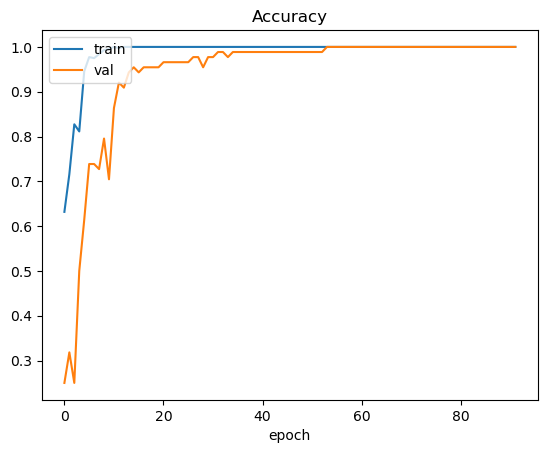

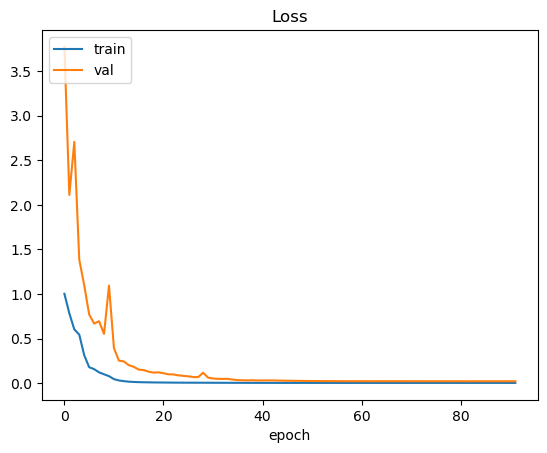

----------------------------------
Accuracy on Test Images :  0.6270270347595215
Loss on Test Images :  1.227641224861145
----------------------------------
Predicted Labels:
 [3 0 3 0 0 1 4 1 2 4 2 3 0 1 3 1 2 1 3 1 2 1 4 2 1 1 0 2 1 4 4 3]
Labels:
 [4 0 3 0 1 1 4 1 2 4 4 3 0 0 4 1 1 1 2 1 1 1 3 2 1 1 0 2 3 2 1 3]


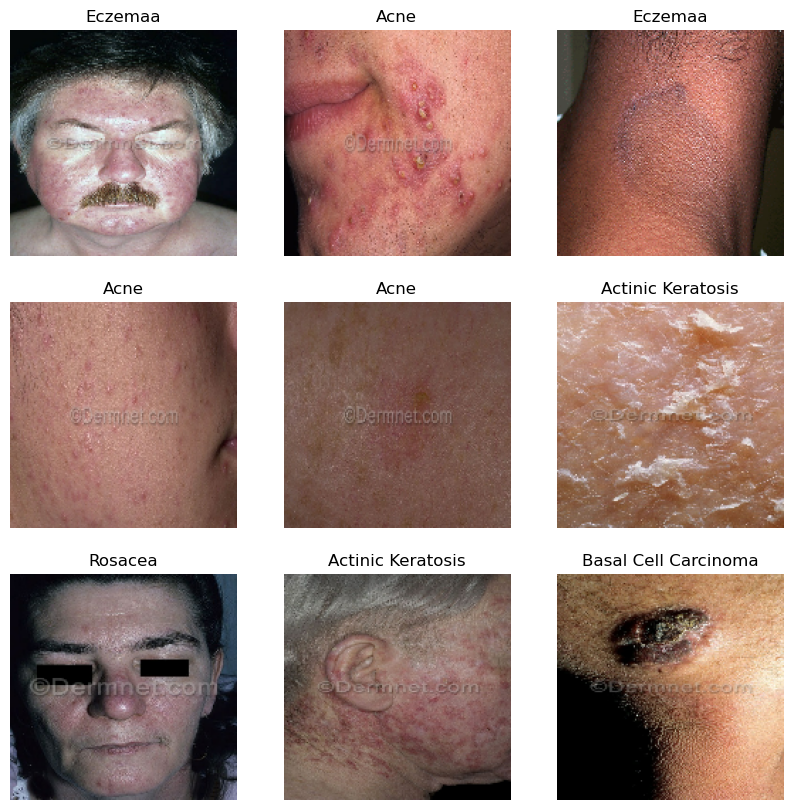

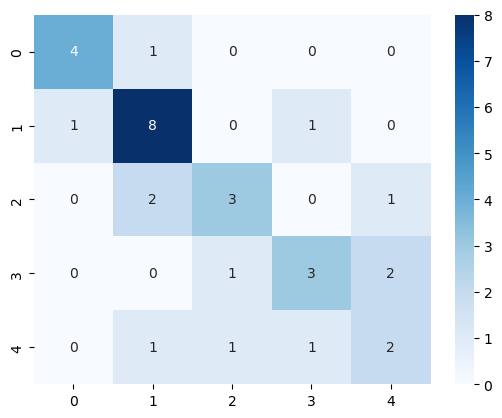

In [ ]:
model_evaluation(model, history)

## Test Model on New Data

In [50]:
loaded_model = tf.keras.models.load_model(model2_save_path)

In [ ]:
test_images_folder0 = "/home/u198181/0image_classification/DATA/testing/Acne/"
test0_predicted_labels, correct0 = model_inference_on_test_images(test_images_folder0,loaded_model, label=0)

test_images_folder1 = "/home/u198181/0image_classification/DATA/testing/Actinic Keratosis/"
test1_predicted_labels, correct1 = model_inference_on_test_images(test_images_folder1,loaded_model, label=1)

test_images_folder2 = "/home/u198181/0image_classification/DATA/testing/Basal Cell Carcinoma/"
test2_predicted_labels, correct2 = model_inference_on_test_images(test_images_folder2,loaded_model, label=2)

test_images_folder3 = "/home/u198181/0image_classification/DATA/testing/Eczemaa/"
test3_predicted_labels, correct3 = model_inference_on_test_images(test_images_folder3,loaded_model, label=3)

test_images_folder4 = "/home/u198181/0image_classification/DATA/testing/Rosacea/"
test4_predicted_labels, correct4 = model_inference_on_test_images(test_images_folder4,loaded_model, label=4)

In [52]:
print("Test Folder 0 - Predicted Labels : \n", test0_predicted_labels)
print("Number of Correct Prediction : " , correct0 )
print("------------------------------------")

print("Test Folder 1 - Predicted Labels : \n", test1_predicted_labels)
print("Number of Correct Prediction : " , correct1 )
print("------------------------------------")

print("Test Folder 2 - Predicted Labels : \n" ,test2_predicted_labels)
print("Number of Correct Prediction : " , correct2 )
print("------------------------------------")

print("Test Folder 3 - Predicted Labels : \n" ,test3_predicted_labels)
print("Number of Correct Prediction : " , correct3 )
print("------------------------------------")

print("Test Folder 4 - Predicted Labels : \n", test4_predicted_labels)
print("Number of Correct Prediction : " , correct4 )
print("------------------------------------")

Test Folder 0 - Predicted Labels : 
 [1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 4, 3, 1, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2]
Number of Correct Prediction :  26
------------------------------------
Test Folder 1 - Predicted Labels : 
 [1, 2, 2, 0, 0, 1, 4, 3, 0, 2, 1, 1, 1, 1, 4, 2, 3, 1, 1, 1, 1, 2, 1, 1, 2, 1, 3, 1, 4, 1, 1, 1, 2, 1, 4, 3, 2]
Number of Correct Prediction :  18
------------------------------------
Test Folder 2 - Predicted Labels : 
 [2, 3, 2, 3, 4, 2, 2, 2, 2, 2, 2, 1, 1, 3, 2, 2, 2, 2, 1, 2, 4, 2, 2, 2, 2, 2, 0, 0, 2, 1, 1, 1, 2, 2, 2, 3, 2]
Number of Correct Prediction :  23
------------------------------------
Test Folder 3 - Predicted Labels : 
 [3, 2, 3, 3, 1, 3, 3, 4, 3, 4, 3, 0, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 0, 2, 0, 3, 1, 3]
Number of Correct Prediction :  20
------------------------------------
Test Folder 4 - Predicted Labels : 
 [0, 1, 0, 4, 1, 4, 1, 4, 0, 0, 4, 1, 4, 4, 4, 4, 4, 1, 4, 4, 1, 4, 4, 4, 3, 4, 3, 4, 

# Transfer Learning with pretrained MobileNet V2

## Base Model + New Classifier

- MobileNetV2 model expects pixel values in [-1, 1].

- The following method is used to rescale them.

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

This was the only modification about data. Since we already created the dataset at the above step, we can directly continue with Model Training part. The dataset will be compatible with this part too.

- First the pretrained model is loaded with weights.

- `include_top=False`, loads a network without classification layers and later this will be used for feature extraction.

In [ ]:
IMG_SIZE = (img_height, img_width)
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

- This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features.

- This can be shown at the below. The first 32 comes from the number of images in a batch.

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2023-08-07 13:07:14.606239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

- Add a classification head

- Converting the features to a single 1280-element vector per image, to generate predictions from the block of features.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


- Dense layer, converts these features into a single prediction per image.

In [ ]:
prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


* Building the model, by putting together the above layers

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [ ]:
len(model.trainable_variables)

2

In [ ]:
totaltime = 0
start = time.time()

history = model.fit(normalized_train_dataset,
                    validation_data=validation_dataset,
                    epochs=200, verbose=1,
                    callbacks=[early_stopping, reduce_lr] )
end = time.time()

totaltime = end - start

print("Training was completed in ",totaltime," seconds.")

Epoch 1/200


2023-08-07 12:19:20.980544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 2.1239 - accuracy: 0.2068

2023-08-07 12:19:24.827124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


14/14 [==============================] - 6s 293ms/step - loss: 2.1239 - accuracy: 0.2068 - val_loss: 2.2720 - val_accuracy: 0.1250 - lr: 1.0000e-04
Epoch 2/200
14/14 [==============================] - 4s 260ms/step - loss: 1.9359 - accuracy: 0.2341 - val_loss: 2.1134 - val_accuracy: 0.1477 - lr: 1.0000e-04
Epoch 3/200
14/14 [==============================] - 4s 270ms/step - loss: 1.9212 - accuracy: 0.2273 - val_loss: 2.0191 - val_accuracy: 0.1705 - lr: 1.0000e-04
Epoch 4/200
14/14 [==============================] - 3s 255ms/step - loss: 1.8900 - accuracy: 0.2250 - val_loss: 1.9706 - val_accuracy: 0.1932 - lr: 1.0000e-04
Epoch 5/200
14/14 [==============================] - 4s 255ms/step - loss: 1.8633 - accuracy: 0.2068 - val_loss: 1.9177 - val_accuracy: 0.1932 - lr: 1.0000e-04
Epoch 6/200
14/14 [==============================] - 3s 248ms/step - loss: 1.8338 - accuracy: 0.2795 - val_loss: 1.8566 - val_accuracy: 0.2159 - lr: 1.0000e-04
Epoch 7/200
14/14 [==============================] -

### Model Evaluation

2023-08-07 12:27:17.446976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


6/6 [==============================] - 1s 133ms/step - loss: 1.0411 - accuracy: 0.6378


2023-08-07 12:27:18.710416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:18.919356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:18.923422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:18.929109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:19.321006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


1/1 [==============================] - 0s 35ms/step


2023-08-07 12:27:19.628635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:19.633350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:19.640359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:19.702464: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:19.707167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:19.714244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:19.781035: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 42ms/step


2023-08-07 12:27:19.848348: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:19.853132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:19.860150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:19.913600: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:19.918132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:19.924997: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:19.982431: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 35ms/step


2023-08-07 12:27:20.054427: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:20.059076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:20.065970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:20.118329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:20.122807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:20.129667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:20.188501: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 32ms/step


2023-08-07 12:27:20.257392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:20.264222: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:20.314092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:20.318544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:20.325390: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:20.392774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:20.397390: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 34ms/step


2023-08-07 12:27:20.459603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:20.466682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:20.527890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:20.532396: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:20.539252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:20.604949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:20.609415: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 45ms/step


2023-08-07 12:27:20.669265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:20.673892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:20.680657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:20.750506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:20.754999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:20.761777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:20.823123: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 47ms/step


2023-08-07 12:27:20.898404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:20.903076: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:20.909932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


1/1 [==============================] - 0s 38ms/step


2023-08-07 12:27:21.426817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:21.431100: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:21.437276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:21.505763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:21.510926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:21.518616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:21.574464: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 48ms/step


2023-08-07 12:27:21.644315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:21.649661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:21.657796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:21.724317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:21.729590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:21.737521: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:21.804660: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 44ms/step


2023-08-07 12:27:21.879785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:21.884838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:21.892567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:21.946077: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:21.950905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:21.958277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:22.020048: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 52ms/step


2023-08-07 12:27:22.095732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:22.101083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:22.108978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:22.174723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:22.179662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:22.187099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:27:22.257397: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 48ms/step


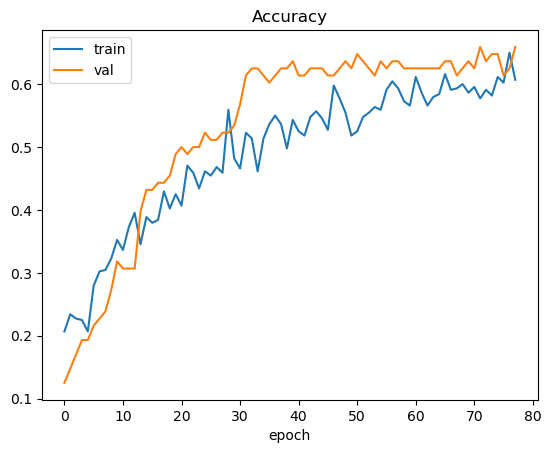

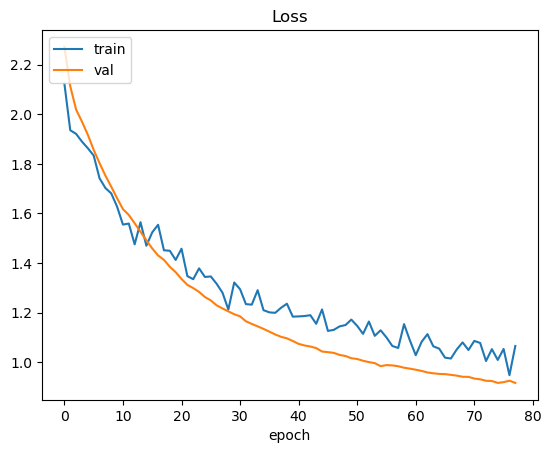

----------------------------------
Accuracy on Test Images :  0.637837827205658
Loss on Test Images :  1.0410672426223755
----------------------------------
Predicted Labels:
 [1 1 4 3 1 1 4 2 2 3 4 3 4 1 3 2 0 4 4 0 2 2 4 3 2 1 0 0 2 1 3 2]
Labels:
 [1 0 0 3 1 1 1 3 2 3 4 3 2 3 1 2 0 4 4 3 2 2 4 3 2 2 3 0 2 1 3 2]


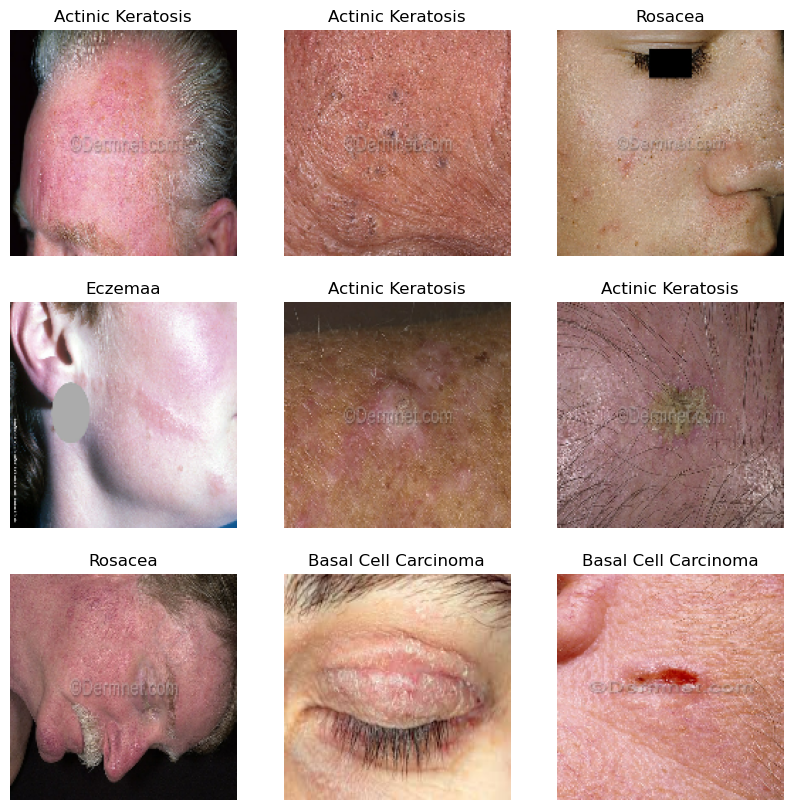

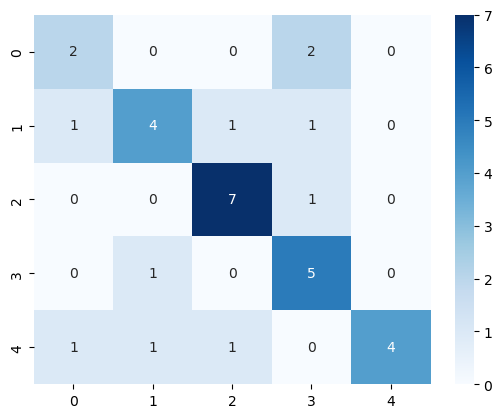

In [ ]:
model_evaluation(model, history)

In [ ]:
test_image_path = "/home/u198181/0image_classification/DATA/testing/Acne/032839HB.jpg"


img = tf.keras.utils.load_img(
    test_image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)

img_array = np.array([img_array]) # Convert single image to a batch.


predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 34ms/step
This image most likely belongs to Acne with a 68.48 percent confidence.


2023-08-07 12:28:33.331691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:28:33.335775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 12:28:33.341462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


In [ ]:
model.save(mobilenet_save_path)

INFO:tensorflow:Assets written to: /home/u198181/0image_classification/tf_mobilenet/assets


INFO:tensorflow:Assets written to: /home/u198181/0image_classification/tf_mobilenet/assets


### Test Model on New Data

In [53]:
loaded_model = tf.keras.models.load_model(mobilenet_save_path)

In [55]:
test_images_folder0 = "/home/u198181/0image_classification/DATA/testing/Acne/"
test0_predicted_labels, correct0 = model_inference_on_test_images(test_images_folder0,loaded_model, label=0)

test_images_folder1 = "/home/u198181/0image_classification/DATA/testing/Actinic Keratosis/"
test1_predicted_labels, correct1 = model_inference_on_test_images(test_images_folder1,loaded_model, label=1)

test_images_folder2 = "/home/u198181/0image_classification/DATA/testing/Basal Cell Carcinoma/"
test2_predicted_labels, correct2 = model_inference_on_test_images(test_images_folder2,loaded_model, label=2)

test_images_folder3 = "/home/u198181/0image_classification/DATA/testing/Eczemaa/"
test3_predicted_labels, correct3 = model_inference_on_test_images(test_images_folder3,loaded_model, label=3)

test_images_folder4 = "/home/u198181/0image_classification/DATA/testing/Rosacea/"
test4_predicted_labels, correct4 = model_inference_on_test_images(test_images_folder4,loaded_model, label=4)

1/1 [==============================] - 0s 46ms/step


2023-08-10 06:23:32.722792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:32.726280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:32.731461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:32.837788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:32.842588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:32.849800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


1/1 [==============================] - 0s 35ms/step


2023-08-10 06:23:32.926531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:32.931413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:32.938449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:33.005748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:33.010357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:33.017306: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:33.088475: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 41ms/step


2023-08-10 06:23:33.164461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:33.169199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:33.176063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:33.240644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:33.245160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:33.251930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:33.311680: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 37ms/step


2023-08-10 06:23:33.391701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:33.396150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:33.402929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:33.474971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:33.479676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:33.486728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:33.552331: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 47ms/step


2023-08-10 06:23:33.638432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:33.643132: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:33.649798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:33.724328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:33.728789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:33.735578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:33.810534: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 39ms/step


2023-08-10 06:23:33.893792: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:33.898462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:33.905314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:33.973336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:33.977673: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:33.984252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:34.050842: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 32ms/step


2023-08-10 06:23:34.133932: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:34.138833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:34.145817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:34.213402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:34.218134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:34.225199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:34.300421: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 52ms/step


2023-08-10 06:23:34.375787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:34.380382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:34.387215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:34.464047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:34.468486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:34.475255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:34.556574: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 36ms/step


2023-08-10 06:23:34.640995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:34.645596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:34.652378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:34.745245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:34.749690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:34.756523: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:34.826820: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 37ms/step


2023-08-10 06:23:34.901796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:34.906646: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:34.913819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:34.982499: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:34.987066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:34.993898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:35.062299: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 33ms/step


2023-08-10 06:23:35.137822: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:35.142280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:35.149070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:35.214419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:35.218924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:35.225743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:35.296728: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - ETA: 0s

2023-08-10 06:23:35.369535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:35.374165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:35.380895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:35.459901: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:35.464604: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:35.471624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:35.536469: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 37ms/step


2023-08-10 06:23:35.613515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:35.618073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:35.624841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:35.697516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:35.701972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:35.708777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:35.775146: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 40ms/step


2023-08-10 06:23:35.863094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:35.867669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:35.874397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:35.940573: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:35.944881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:35.951517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:36.017382: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 33ms/step


2023-08-10 06:23:36.102799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:36.107660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:36.114707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:36.181124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:36.185823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:36.192878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:36.255972: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 35ms/step


2023-08-10 06:23:36.329873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:36.334517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:36.341493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:36.403430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:36.407886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:36.414828: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:36.495430: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 35ms/step


2023-08-10 06:23:36.571624: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:36.576175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:36.582895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:36.644917: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:36.649367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:36.656255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:36.731491: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 47ms/step


2023-08-10 06:23:36.813893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:36.818726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:36.825653: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:36.892255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:36.896770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:36.903533: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:36.978709: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 34ms/step


2023-08-10 06:23:37.059718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:37.064296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:37.071018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:37.135940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:37.140479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:37.147392: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:37.210670: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 40ms/step


2023-08-10 06:23:37.286884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:37.291463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:37.298360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:37.374650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:37.379315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:37.386373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:37.455207: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 40ms/step


2023-08-10 06:23:37.540458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:37.545239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:37.552062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:37.638518: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:37.643103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:37.649891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:37.718471: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 44ms/step


2023-08-10 06:23:37.797062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:37.801686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:37.808473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:37.880160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:37.884582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:37.891300: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:37.965116: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 43ms/step


2023-08-10 06:23:38.060448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:38.065377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:38.072526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:38.140804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:38.145538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:38.152593: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:38.224557: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 44ms/step


2023-08-10 06:23:38.312465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:38.317086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:38.323883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:38.395131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:38.399595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:38.406359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:38.479629: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 36ms/step


2023-08-10 06:23:38.568402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:38.573062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:38.579805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:38.654018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:38.658498: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:38.665271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:38.735511: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 42ms/step


2023-08-10 06:23:38.825174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:38.830038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:38.837048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:38.909246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:38.913794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:38.920633: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:38.990314: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 34ms/step


2023-08-10 06:23:39.073534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:39.078148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:39.084920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:39.151407: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:39.155830: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:39.162585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:39.228599: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 44ms/step


2023-08-10 06:23:39.305296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:39.309885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:39.316596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:39.398000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:39.402694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:39.409807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:39.484199: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 39ms/step


2023-08-10 06:23:39.567948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:39.572665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:39.579649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:39.650508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:39.654995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:39.661794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:39.730242: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 39ms/step


2023-08-10 06:23:39.811974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:39.816582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:39.823384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:39.897824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:39.902254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:39.909164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:39.978017: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 39ms/step


2023-08-10 06:23:40.065230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:40.070178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:40.077356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:40.141511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:40.146553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:40.153578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:40.221682: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 46ms/step


2023-08-10 06:23:40.300936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:40.305522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:40.312218: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:40.390500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:40.394931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:40.401680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:40.477477: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 49ms/step


2023-08-10 06:23:40.563798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:40.568436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:40.575226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:40.657092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:40.661553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:40.668324: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:40.753214: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 31ms/step


2023-08-10 06:23:40.766763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:40.833548: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:40.838237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:40.845232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:40.920888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:40.925503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:40.932483: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 47ms/step


2023-08-10 06:23:40.993491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:40.998105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:41.004816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:41.075549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:41.080172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:41.087029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:41.164785: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 50ms/step


2023-08-10 06:23:41.256681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:41.261288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:41.268051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:41.346360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:41.350820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:41.357576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:41.441652: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 45ms/step


2023-08-10 06:23:41.525703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:41.530609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:41.537659: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:41.607484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:41.612081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:41.618954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:41.694298: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 47ms/step


2023-08-10 06:23:41.781867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:41.786515: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:41.793315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:41.861563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:41.866061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:41.872900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:41.949640: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 58ms/step


2023-08-10 06:23:42.033268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:42.037880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:42.044671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:42.109383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:42.114021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:42.121070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:42.203701: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 41ms/step


2023-08-10 06:23:42.322887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:42.327661: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:42.334532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:42.401745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:42.406207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:42.413037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:42.473466: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 47ms/step


2023-08-10 06:23:42.555861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:42.560456: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:42.567339: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:42.629931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:42.634388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:42.641174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:42.724406: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 48ms/step


2023-08-10 06:23:42.811151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:42.815995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:42.823429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:42.904291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:42.909018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:42.916183: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


1/1 [==============================] - 0s 45ms/step


2023-08-10 06:23:43.039150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:43.043883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:43.050704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:43.156812: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:43.161374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:43.168175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


1/1 [==============================] - 0s 45ms/step


2023-08-10 06:23:43.244814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:43.249425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:43.256259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:43.326467: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:43.330878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:43.337677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


1/1 [==============================] - 0s 36ms/step


2023-08-10 06:23:43.457216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:43.462029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:43.468882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:43.539562: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:43.543859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:43.550475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:43.627588: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 36ms/step


2023-08-10 06:23:43.718553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:43.723409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:43.730347: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:43.791429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:43.795926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:43.802701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:43.867981: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 35ms/step


2023-08-10 06:23:43.938800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:43.943395: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:43.950143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:44.023776: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:44.028294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:44.035087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:44.103712: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 50ms/step


2023-08-10 06:23:44.174691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:44.179209: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:44.186065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:44.249227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:44.253905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:44.260981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:44.341437: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 39ms/step


2023-08-10 06:23:44.461092: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:44.465943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:44.472820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:44.537882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:44.542244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:44.548907: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:44.611988: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - ETA: 0s

2023-08-10 06:23:44.694382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:44.699001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:44.706203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:44.781328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:44.785755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:44.792496: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:44.862226: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 47ms/step


2023-08-10 06:23:44.936879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:44.941591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:44.948731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:45.019247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:45.023889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:45.031041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:45.107285: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 39ms/step


2023-08-10 06:23:45.184671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:45.189302: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:45.196109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:45.260969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:45.265473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:45.272354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:45.333179: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 40ms/step


2023-08-10 06:23:45.413577: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:45.418232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:45.425097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:45.488615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:45.493047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:45.499834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:45.566106: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 40ms/step


2023-08-10 06:23:45.648770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:45.653660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:45.660790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:45.738891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:45.743410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:45.750238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:45.821116: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 35ms/step


2023-08-10 06:23:45.908946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:45.913639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:45.920479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:45.996524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:46.001001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:46.007779: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:46.075210: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 51ms/step


2023-08-10 06:23:46.150679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:46.155401: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:46.162159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:46.244972: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:46.249559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:46.256448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:46.337112: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 41ms/step


2023-08-10 06:23:46.431418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:46.436156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:46.443006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:46.513922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:46.518376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:46.525124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:46.598437: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 32ms/step


2023-08-10 06:23:46.683790: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:46.688388: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:46.695026: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:46.762805: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:46.767251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:46.774062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:46.842133: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 37ms/step


2023-08-10 06:23:46.919386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:46.924332: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:46.931424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:46.999470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:47.004236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:47.011317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:47.069948: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 34ms/step


2023-08-10 06:23:47.146472: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:47.150989: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:47.157791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:47.241739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:47.246207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:47.253063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:47.317957: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 46ms/step


2023-08-10 06:23:47.402693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:47.407316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:47.414105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:47.489060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:47.493516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:47.500313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:47.580777: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 41ms/step


2023-08-10 06:23:47.662541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:47.667476: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:47.674542: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:47.740841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:47.745370: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:47.752212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:47.826060: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 40ms/step


2023-08-10 06:23:47.920495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:47.925715: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:47.933567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:48.002734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:48.007752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:23:48.015591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


In [57]:
print("Test Folder 0 - Predicted Labels : \n", test0_predicted_labels)
print("Number of Correct Prediction : " , correct0 )
print("------------------------------------")

print("Test Folder 1 - Predicted Labels : \n", test1_predicted_labels)
print("Number of Correct Prediction : " , correct1 )
print("------------------------------------")

print("Test Folder 2 - Predicted Labels : \n" ,test2_predicted_labels)
print("Number of Correct Prediction : " , correct2 )
print("------------------------------------")

print("Test Folder 3 - Predicted Labels : \n" ,test3_predicted_labels)
print("Number of Correct Prediction : " , correct3 )
print("------------------------------------")

print("Test Folder 4 - Predicted Labels : \n", test4_predicted_labels)
print("Number of Correct Prediction : " , correct4 )
print("------------------------------------")

Test Folder 0 - Predicted Labels : 
 [1, 0, 0, 0, 1, 4, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 2, 4, 0, 3]
Number of Correct Prediction :  22
------------------------------------
Test Folder 1 - Predicted Labels : 
 [1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 3, 1, 1, 1, 1, 1]
Number of Correct Prediction :  31
------------------------------------
Test Folder 2 - Predicted Labels : 
 [4, 3, 2, 3, 2, 1, 1, 2, 2, 1, 2, 2, 1, 4, 1, 1, 4, 1, 2, 2, 4, 2, 2, 2, 2, 4, 2, 4, 1, 2, 4, 1, 3, 3, 1, 2, 1]
Number of Correct Prediction :  15
------------------------------------
Test Folder 3 - Predicted Labels : 
 [4, 1, 0, 1, 4, 3, 1, 4, 3, 3, 0, 3, 3, 3, 1, 3, 3, 4, 0, 2, 3, 2, 0, 3, 0, 2, 3, 1, 0, 3, 1, 1, 1, 3, 1]
Number of Correct Prediction :  13
------------------------------------
Test Folder 4 - Predicted Labels : 
 [4, 3, 4, 4, 2, 1, 2, 1, 0, 1, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 1, 4, 1, 4, 

## Fine tuning

- In the previous part, the weights of the pre-trained network were not updated during training.

- Now they will be also trained. This will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                             

In [ ]:
len(model.trainable_variables)

56

In [ ]:
totaltime = 0
start = time.time()

history = model.fit(normalized_train_dataset,
                    validation_data=validation_dataset,
                    epochs=200, verbose=1,
                    callbacks=[early_stopping, reduce_lr] )
end = time.time()

totaltime = end - start

print("Training was completed in ",totaltime," seconds.")

Epoch 1/200


2023-08-07 13:09:06.592330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:09:07.871911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


14/14 [==============================] - ETA: 0s - loss: 1.6853 - accuracy: 0.3068

2023-08-07 13:09:13.321731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:09:13.576594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


14/14 [==============================] - 11s 370ms/step - loss: 1.6853 - accuracy: 0.3068 - val_loss: 1.3210 - val_accuracy: 0.5227 - lr: 1.0000e-04
Epoch 2/200
14/14 [==============================] - 4s 296ms/step - loss: 1.3426 - accuracy: 0.4841 - val_loss: 1.1797 - val_accuracy: 0.6136 - lr: 1.0000e-04
Epoch 3/200
14/14 [==============================] - 4s 312ms/step - loss: 1.2383 - accuracy: 0.4932 - val_loss: 1.0467 - val_accuracy: 0.5568 - lr: 1.0000e-04
Epoch 4/200
14/14 [==============================] - 5s 332ms/step - loss: 1.1035 - accuracy: 0.5864 - val_loss: 0.8131 - val_accuracy: 0.6364 - lr: 1.0000e-04
Epoch 5/200
14/14 [==============================] - 4s 302ms/step - loss: 0.9861 - accuracy: 0.6136 - val_loss: 0.9799 - val_accuracy: 0.6136 - lr: 1.0000e-04
Epoch 6/200
14/14 [==============================] - 4s 313ms/step - loss: 1.0487 - accuracy: 0.6068 - val_loss: 0.7851 - val_accuracy: 0.6818 - lr: 1.0000e-04
Epoch 7/200
14/14 [==============================] 

In [ ]:
model.save(mobilenet_fine_save_path)

INFO:tensorflow:Assets written to: /home/u198181/0image_classification/tf_mobilenet_fine/assets


INFO:tensorflow:Assets written to: /home/u198181/0image_classification/tf_mobilenet_fine/assets


### Model Evaluation

2023-08-07 13:18:08.583609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


6/6 [==============================] - 1s 138ms/step - loss: 0.8438 - accuracy: 0.6811


2023-08-07 13:18:09.960139: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:10.286658: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:10.292582: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:10.300098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:10.847250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


1/1 [==============================] - 0s 32ms/step


2023-08-07 13:18:11.169954: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:11.174773: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:11.181774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:11.248414: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:11.253115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:11.260213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:11.323597: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 32ms/step


2023-08-07 13:18:11.387796: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:11.392495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:11.399439: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:11.465986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:11.470575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:11.477603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:11.535393: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 44ms/step


2023-08-07 13:18:11.598114: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:11.602832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:11.609720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:11.661048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:11.665458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:11.672205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:11.736952: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 45ms/step


2023-08-07 13:18:11.811924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:11.816601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:11.823489: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:11.871599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:11.876122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:11.882976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:11.948731: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 46ms/step


2023-08-07 13:18:12.028485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:12.033258: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:12.040355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:12.103667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:12.108136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:12.114885: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:12.179190: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 32ms/step


2023-08-07 13:18:12.259066: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:12.268150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:12.275104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:12.342757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:12.347195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:12.353897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:12.406701: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 51ms/step


2023-08-07 13:18:12.469006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:12.473677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:12.480552: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:12.546682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:12.551232: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:12.558177: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:12.614720: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 50ms/step


2023-08-07 13:18:12.696371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:12.701151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:12.708071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:12.762397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:12.767032: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:12.773993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:12.828099: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 39ms/step


2023-08-07 13:18:12.912012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:12.916744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:12.923704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:12.990352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:12.994962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:13.001923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:13.055303: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 47ms/step


2023-08-07 13:18:13.125096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:13.129815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:13.136697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:13.195188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:13.199844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:13.206913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:13.258702: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 35ms/step


2023-08-07 13:18:13.338422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:13.343145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:13.350039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


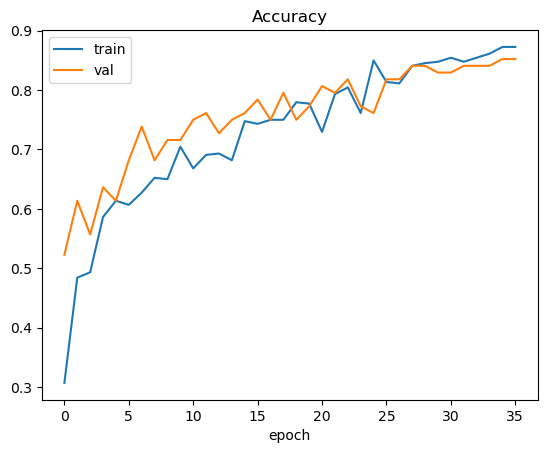

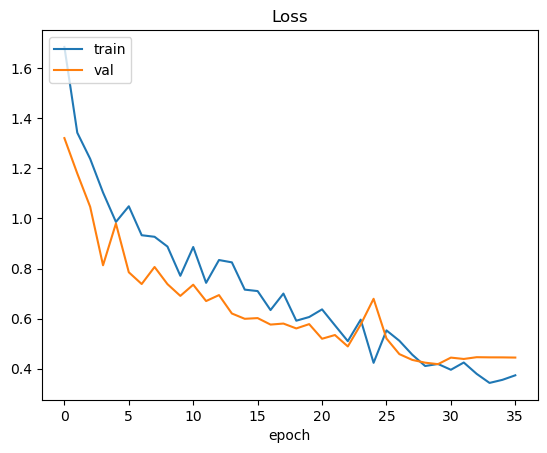

----------------------------------
Accuracy on Test Images :  0.6810810565948486
Loss on Test Images :  0.8437606692314148
----------------------------------
Predicted Labels:
 [3 4 3 4 3 3 1 0 0 0 4 1 2 0 4 4 4 0 1 4 0 3 2 1 0 1 3 2 2 4 4 2]
Labels:
 [3 4 1 3 3 3 1 0 0 0 4 2 0 0 1 1 4 0 1 1 0 3 3 0 0 1 4 2 2 4 4 2]


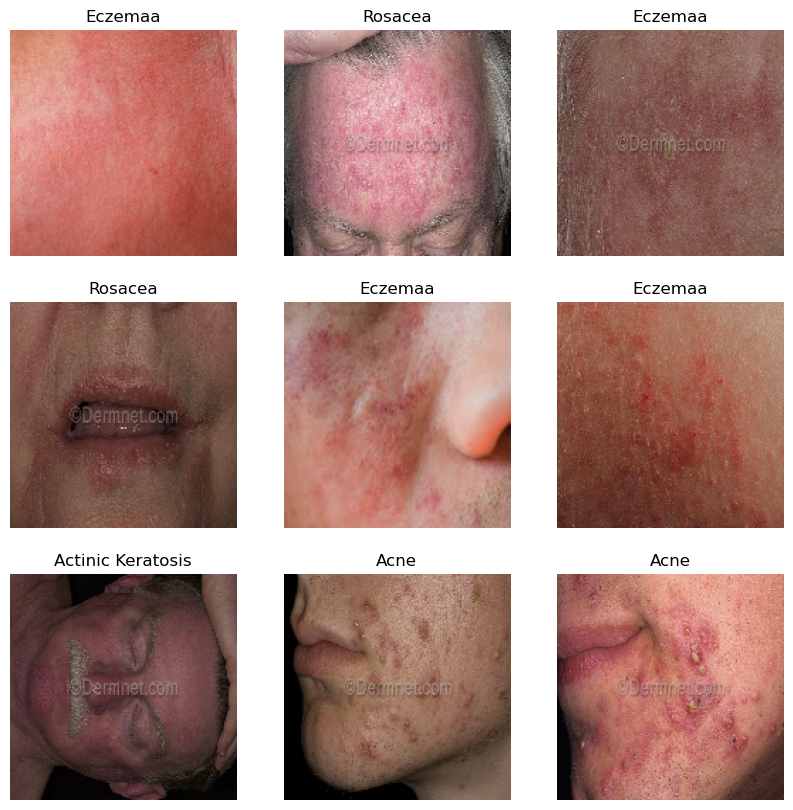

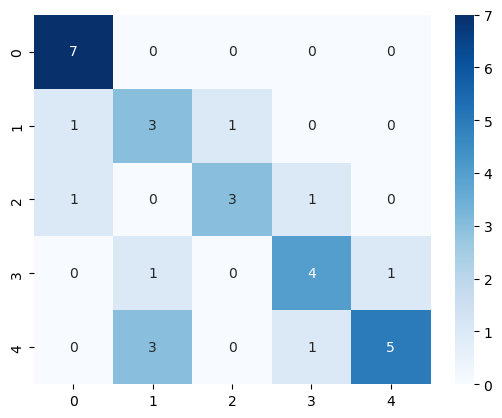

In [ ]:
model_evaluation(model, history)

In [ ]:
test_image_path = "/home/u198181/0image_classification/DATA/testing/Acne/032839HB.jpg"


img = tf.keras.utils.load_img(
    test_image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)

img_array = np.array([img_array]) # Convert single image to a batch.


predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 46ms/step
This image most likely belongs to Acne with a 66.71 percent confidence.


2023-08-07 13:18:40.087818: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:40.092341: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-07 13:18:40.098918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


### Test Model on New Data

In [58]:
loaded_model = tf.keras.models.load_model(mobilenet_fine_save_path)

In [59]:
test_images_folder0 = "/home/u198181/0image_classification/DATA/testing/Acne/"
test0_predicted_labels, correct0 = model_inference_on_test_images(test_images_folder0,loaded_model, label=0)

test_images_folder1 = "/home/u198181/0image_classification/DATA/testing/Actinic Keratosis/"
test1_predicted_labels, correct1 = model_inference_on_test_images(test_images_folder1,loaded_model, label=1)

test_images_folder2 = "/home/u198181/0image_classification/DATA/testing/Basal Cell Carcinoma/"
test2_predicted_labels, correct2 = model_inference_on_test_images(test_images_folder2,loaded_model, label=2)

test_images_folder3 = "/home/u198181/0image_classification/DATA/testing/Eczemaa/"
test3_predicted_labels, correct3 = model_inference_on_test_images(test_images_folder3,loaded_model, label=3)

test_images_folder4 = "/home/u198181/0image_classification/DATA/testing/Rosacea/"
test4_predicted_labels, correct4 = model_inference_on_test_images(test_images_folder4,loaded_model, label=4)

2023-08-10 06:24:47.024418: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:47.028016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:47.033275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:47.371799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


1/1 [==============================] - 0s 42ms/step


2023-08-10 06:24:47.692853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:47.697884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:47.705082: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:47.792748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:47.797501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:47.804833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:47.878969: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 46ms/step


2023-08-10 06:24:47.970565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:47.975374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:47.982199: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:48.071408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:48.076008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:48.082990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:48.159101: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 45ms/step


2023-08-10 06:24:48.237505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:48.242064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:48.248734: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:48.323357: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:48.327826: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:48.334671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:48.409787: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 47ms/step


2023-08-10 06:24:48.495834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:48.500992: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:48.508145: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:48.584404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:48.589178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:48.596278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:48.672614: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 48ms/step


2023-08-10 06:24:48.758316: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:48.763013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:48.769864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:48.838373: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:48.842903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:48.849710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:48.924714: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 44ms/step


2023-08-10 06:24:49.009911: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:49.014553: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:49.021437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:49.085255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:49.089539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:49.096315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:49.176068: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 50ms/step


2023-08-10 06:24:49.259016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:49.263929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:49.271275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:49.349364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:49.353942: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:49.360869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:49.440918: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 40ms/step


2023-08-10 06:24:49.525143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:49.529811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:49.536683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:49.608557: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:49.613024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:49.619806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:49.712158: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 51ms/step


2023-08-10 06:24:49.815081: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:49.819706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:49.826514: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:49.897110: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:49.901785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:49.908900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:49.990537: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 51ms/step


2023-08-10 06:24:50.079058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:50.083819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:50.090810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:50.169358: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:50.173813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:50.180629: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:50.263918: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - ETA: 0s

2023-08-10 06:24:50.347692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:50.352365: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:50.359156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:50.433296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:50.438055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:50.444860: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:50.511405: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 42ms/step


2023-08-10 06:24:50.598187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:50.603078: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:50.610146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:50.689780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:50.694485: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:50.701494: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:50.773543: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 46ms/step


2023-08-10 06:24:50.858691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:50.863361: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:50.870119: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:50.961635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:50.966154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:50.972919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:51.048961: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 50ms/step


2023-08-10 06:24:51.061893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:51.132733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:51.137178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:51.143985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:51.224430: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:51.228843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:51.235659: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 47ms/step


2023-08-10 06:24:51.316903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:51.321837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:51.328931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:51.403260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:51.407902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:51.414915: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:51.492268: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 42ms/step


2023-08-10 06:24:51.571377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:51.575811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:51.582555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:51.648206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:51.652685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:51.659512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:51.733268: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 48ms/step


2023-08-10 06:24:51.819912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:51.824539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:51.831356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:51.914429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:51.918904: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:51.925720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:52.006621: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 35ms/step


2023-08-10 06:24:52.085844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:52.090764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:52.097867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:52.159616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:52.164277: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:52.171567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:52.236261: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 46ms/step


2023-08-10 06:24:52.313579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:52.318131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:52.324928: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:52.388480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:52.392938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:52.400219: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:52.477926: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 48ms/step


2023-08-10 06:24:52.565632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:52.570012: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:52.576756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:52.645685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:52.650409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:52.657506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:52.736491: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 54ms/step


2023-08-10 06:24:52.824178: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:52.828981: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:52.835974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:52.907605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:52.912011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:52.918660: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:53.004679: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 44ms/step


2023-08-10 06:24:53.094877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:53.099512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:53.106275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:53.185545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:53.190019: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:53.196845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:53.270554: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 46ms/step


2023-08-10 06:24:53.353230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:53.358136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:53.365202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:53.447908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:53.452697: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:53.459786: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:53.535294: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 49ms/step


2023-08-10 06:24:53.616861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:53.621516: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:53.628336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:53.695890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:53.700359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:53.707165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:53.786329: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 53ms/step


2023-08-10 06:24:53.873819: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:53.878461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:53.885412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:53.953909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:53.958387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:53.965165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:54.055476: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 39ms/step


2023-08-10 06:24:54.141607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:54.147005: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:54.155137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:54.237068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:54.242202: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:54.250315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:54.322673: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 35ms/step


2023-08-10 06:24:54.405746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:54.410982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:54.418859: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:54.485983: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:54.491063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:54.498900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:54.568772: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 47ms/step


2023-08-10 06:24:54.648704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:54.653961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:54.662022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:54.741490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:54.746857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:54.755117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:54.832962: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 52ms/step


2023-08-10 06:24:54.915186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:54.920549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:54.928563: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:55.004383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:55.008839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:55.015541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:55.099583: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 43ms/step


2023-08-10 06:24:55.189473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:55.194146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:55.200976: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:55.277495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:55.281947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:55.288784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:55.366388: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 45ms/step


2023-08-10 06:24:55.462597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:55.467413: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:55.474336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:55.554172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:55.558883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:55.565898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:55.646162: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 56ms/step


2023-08-10 06:24:55.748559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:55.753879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:55.761754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:55.839636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:55.844708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:55.852632: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:55.941546: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 37ms/step


2023-08-10 06:24:55.954501: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:56.023681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:56.028702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:56.036526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:56.110280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:56.115317: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:56.123210: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 42ms/step


2023-08-10 06:24:56.196535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:56.201369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:56.208346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:56.287194: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:56.291938: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:56.299027: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:56.370933: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 47ms/step


2023-08-10 06:24:56.461136: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:56.465704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:56.472403: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:56.543389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:56.547914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:56.554890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:56.630872: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 45ms/step


2023-08-10 06:24:56.721213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:56.725898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:56.732742: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:56.813683: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:56.818184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:56.825023: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:56.907260: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 36ms/step


2023-08-10 06:24:56.992780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:56.997719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:57.004770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:57.078540: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:57.083121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:57.089916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:57.157738: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 42ms/step


2023-08-10 06:24:57.247386: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:57.252107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:57.258939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:57.337438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:57.341966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:57.348800: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:57.421231: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 33ms/step


2023-08-10 06:24:57.501431: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:57.506095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:57.513045: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:57.588881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:57.593686: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:57.600986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:57.699134: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 45ms/step


2023-08-10 06:24:57.705762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:57.713030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:57.787803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:57.792425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:57.799307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:57.875257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:57.879774: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 40ms/step


2023-08-10 06:24:57.967129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:57.971763: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:57.978711: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:58.057583: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:58.062016: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:58.068780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:58.145561: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 48ms/step


2023-08-10 06:24:58.223210: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:58.227811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:58.234797: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:58.319591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:58.324304: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:58.331423: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


1/1 [==============================] - 0s 44ms/step


2023-08-10 06:24:58.457761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:58.462726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:58.469846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:58.584371: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:58.589008: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:58.595863: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


1/1 [==============================] - 0s 43ms/step


2023-08-10 06:24:58.671908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:58.676532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:58.683354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:58.752566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:58.756999: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:58.763811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


1/1 [==============================] - 0s 38ms/step


2023-08-10 06:24:58.882224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:58.886899: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:58.893676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:58.970943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:58.975404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:58.982217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:59.059739: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 51ms/step


2023-08-10 06:24:59.154057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:59.159010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:59.166094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:59.243282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:59.247919: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:59.254749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:59.334771: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 45ms/step


2023-08-10 06:24:59.405487: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:59.410037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:59.416665: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:59.497861: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:59.502291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:59.509070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:59.583822: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 47ms/step


2023-08-10 06:24:59.656126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:59.660723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:59.667397: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:59.729895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:59.734369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:59.741314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:59.823996: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 39ms/step


2023-08-10 06:24:59.941799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:59.946936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:24:59.954168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:00.022419: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:00.027068: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:00.033941: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:00.104182: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - ETA: 0s

2023-08-10 06:25:00.193266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:00.197947: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:00.204846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:00.279843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:00.284299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:00.291115: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:00.353545: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 39ms/step


2023-08-10 06:25:00.437757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:00.442647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:00.450314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:00.525164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:00.530525: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:00.538759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:00.610983: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 36ms/step


2023-08-10 06:25:00.697517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:00.702897: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:00.710784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:00.779276: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:00.784376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:00.792308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:00.861031: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 40ms/step


2023-08-10 06:25:00.956446: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:00.961726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:00.969668: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:01.043780: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:01.048111: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:01.054754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:01.126083: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 54ms/step


2023-08-10 06:25:01.219106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:01.224551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:01.232647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:01.320705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:01.326047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:01.334185: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


1/1 [==============================] - 0s 51ms/step


2023-08-10 06:25:01.424571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:01.430978: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:01.439508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:01.538238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:01.543085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:01.550212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


1/1 [==============================] - 0s 45ms/step


2023-08-10 06:25:01.635127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:01.640025: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:01.647693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:01.753705: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:01.758265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:01.765743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


1/1 [==============================] - 0s 47ms/step


2023-08-10 06:25:01.842558: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:01.847236: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:01.854055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:01.927995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:01.932595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:01.939678: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:02.023509: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 63ms/step


2023-08-10 06:25:02.116065: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:02.121356: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:02.128598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:02.249889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:02.259526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:02.271465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


1/1 [==============================] - 0s 56ms/step


2023-08-10 06:25:02.416299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:02.425448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:02.438252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:02.534672: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:02.539103: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:02.545775: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


1/1 [==============================] - 0s 43ms/step


2023-08-10 06:25:02.631491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:02.636175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:02.642993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:02.716122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:02.720579: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:02.727359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:02.801347: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 51ms/step


2023-08-10 06:25:02.904961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:02.909635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:02.916721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:03.021628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:03.026571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:03.033544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


1/1 [==============================] - 0s 45ms/step


2023-08-10 06:25:03.113213: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:03.117939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:03.124834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:03.199036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:03.203627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:03.210616: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:03.285157: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 48ms/step


2023-08-10 06:25:03.366864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:03.371488: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:03.378275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:03.455192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:03.459641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:03.466417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:03.545137: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 42ms/step


2023-08-10 06:25:03.641726: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:03.646602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:03.653565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:03.738161: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:03.742874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:03.749916: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:03.823260: I tensorflow/core/grappler/optimizers/cust

1/1 [==============================] - 0s 49ms/step


2023-08-10 06:25:03.917642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:03.921970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:03.928568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:04.005929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:04.010375: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-08-10 06:25:04.017085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


In [60]:
print("Test Folder 0 - Predicted Labels : \n", test0_predicted_labels)
print("Number of Correct Prediction : " , correct0 )
print("------------------------------------")

print("Test Folder 1 - Predicted Labels : \n", test1_predicted_labels)
print("Number of Correct Prediction : " , correct1 )
print("------------------------------------")

print("Test Folder 2 - Predicted Labels : \n" ,test2_predicted_labels)
print("Number of Correct Prediction : " , correct2 )
print("------------------------------------")

print("Test Folder 3 - Predicted Labels : \n" ,test3_predicted_labels)
print("Number of Correct Prediction : " , correct3 )
print("------------------------------------")

print("Test Folder 4 - Predicted Labels : \n", test4_predicted_labels)
print("Number of Correct Prediction : " , correct4 )
print("------------------------------------")

Test Folder 0 - Predicted Labels : 
 [0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 4, 0, 3, 4, 2, 0, 0, 0, 0, 4, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0]
Number of Correct Prediction :  28
------------------------------------
Test Folder 1 - Predicted Labels : 
 [0, 1, 1, 1, 0, 1, 0, 1, 4, 2, 1, 4, 4, 1, 4, 1, 1, 4, 1, 3, 1, 4, 0, 1, 1, 4, 0, 1, 1, 2, 3, 3, 1, 2, 1, 1, 1]
Number of Correct Prediction :  19
------------------------------------
Test Folder 2 - Predicted Labels : 
 [2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 4, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2]
Number of Correct Prediction :  30
------------------------------------
Test Folder 3 - Predicted Labels : 
 [4, 1, 3, 1, 4, 3, 3, 4, 3, 3, 3, 3, 3, 3, 1, 3, 3, 4, 3, 3, 3, 2, 3, 3, 1, 1, 3, 2, 0, 3, 2, 3, 1, 3, 1]
Number of Correct Prediction :  20
------------------------------------
Test Folder 4 - Predicted Labels : 
 [3, 2, 4, 4, 2, 1, 3, 4, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 0, 4, 1, 4, 4, 4, 